# Paralelizacion

In [93]:
import ipyparallel as ipp

import numpy
import matplotlib.pyplot as plt

from scipy.optimize import root
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.integrate import simpson

from scipy.stats import linregress

plt.style.use('bmh')


plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["figure.titlesize"] = 20

## Funciones necesarias para simular

In [167]:
beta = 8
gamma = 1/2
u_max = 20
rho_max = 1/7.5
c = 0.078 * u_max * rho_max
b = 1/3
l = 1/10

# Define u en función de rho e y
def u(rho, y, h):
    output = y/rho - h(rho)
    return output


# Define y en función de rho y u
def y_u(rho, u, h):
    output = rho*(u + h(rho))
    return output


# Flujo del modelo
def flux(Q, h):
    
    # Rescata variables
    rho, y = Q

    return numpy.array([y-rho*h(rho), (y**2)/rho - h(rho)*y])


# Flujo con HLL
def F_HLL(Q, N, U, h, dx):

    # Guarda flujo en un arreglo
    F_ = np.zeros(Q.shape)

    def phi(r):
        r_1, r_2 = r
        output_1 = np.max([0, np.min([1, r_1])])
        output_2 = np.max([0, np.min([1, r_2])])
        output = np.array([output_1, output_2])
        return output

    for i in range(2, N-2):
        
        # Rescata actual y vecinos
        Q_left_left = Q[:, i-2]
        Q_left = Q[:, i-1]
        Q_i = Q[:, i]
        Q_right = Q[:, i+1]
        Q_right_right = Q[:, i+2]

        r_left = (Q_left - Q_left_left)/(Q_i - Q_left)
        r_i = (Q_i - Q_left)/(Q_right - Q_i)
        r_right = (Q_right - Q_i)/(Q_right_right - Q_right)

        Q_L = Q_i + (1/2) * phi(r_i) * (Q_right - Q_i)
        Q_L_ = Q_left + (1/2) * phi(r_left) * (Q_i - Q_left)

        Q_R = Q_right - (1/2) * phi(r_right) * (Q_right_right - Q_right)
        Q_R_ = Q_i - (1/2) * phi(r_i) * (Q_right - Q_i)


        # Evalúa en el flujo HLL
        F_[:, i] = flux_HLL(Q_L, Q_R, h) - flux_HLL(Q_L_, Q_R_, h) #flux_HLL(Q_i, Q_right, h) - flux_HLL(Q_left, Q_i, h)

    # Asume condiciones de borde periódicas
    Q_0 = Q[:, 0]
    Q_1 = Q[:, 1]
    Q_2 = Q[:, 2]
    Q_3 = Q[:, 3]
    Q_ult = Q[:, -1]
    Q_pen = Q[:, -2]
    Q_antp = Q[:, -3]
    Q_antantp = Q[:, -4]
    
    # i = 1
    r_0 = (Q_ult - Q_pen)/(Q_1 - Q_ult)
    r_1 = (Q_1 - Q_0)/(Q_2 - Q_1)
    r_2 = (Q_2 - Q_1)/(Q_3 - Q_2)

    Q_L_1 = Q_1 + (1/2) * phi(r_1) * (Q_2 - Q_1)
    Q_L_1_ = Q_ult + (1/2) * phi(r_0) * (Q_1 - Q_ult)

    Q_R_1 = Q_2 - (1/2) * phi(r_2) * (Q_3 - Q_2)
    Q_R_1_ = Q_1 - (1/2) * phi(r_1) * (Q_2 - Q_1)

    per_1 = flux_HLL(Q_L_1, Q_R_1, h) - flux_HLL(Q_L_1_, Q_R_1_, h)


    # i = 0
    r_left = (Q_pen - Q_antp)/(Q_ult - Q_pen)
    r_0 = (Q_ult - Q_pen)/(Q_1 - Q_ult)
    r_right = (Q_1 - Q_0)/(Q_2 - Q_1)

    Q_L_0 = Q_ult + (1/2) * phi(r_0) * (Q_1 - Q_ult)
    Q_L_0_ = Q_pen + (1/2) * phi(r_left) * (Q_ult - Q_pen)

    Q_R_0 = Q_1 - (1/2) * phi(r_right) * (Q_2 - Q_1)
    Q_R_0_ = Q_ult - (1/2) * phi(r_0) * (Q_1 - Q_ult)

    per = flux_HLL(Q_L_0, Q_R_0, h) - flux_HLL(Q_L_0_, Q_R_0_, h)

    # i = N-1
    r_antp = (Q_antp - Q_antantp)/(Q_pen - Q_antp)
    r_pen = (Q_pen - Q_antp)/(Q_ult - Q_pen)
    r_ult = (Q_ult - Q_pen)/(Q_1 - Q_ult)

    Q_L_N_1 = Q_pen + (1/2) * phi(r_pen) * (Q_ult - Q_pen)
    Q_L_N_1_ = Q_antp + (1/2) * phi(r_antp) * (Q_pen - Q_antp)

    Q_R_N_1 = Q_ult - (1/2) * phi(r_ult) * (Q_1 - Q_ult)
    Q_R_N_1_ = Q_pen - (1/2) * phi(r_pen) * (Q_ult - Q_pen)

    per_2 = flux_HLL(Q_L_N_1, Q_R_N_1, h) - flux_HLL(Q_L_N_1_, Q_R_N_1_, h)
    
    F_[:, 1] = per_1
    F_[:, 0] = per
    F_[:, -1] = per
    F_[:, -2] = per_2

    return F_


# Funciones del modelo
# Función de duda
def h(rho):
    if type(rho) is float or type(rho) is numpy.float64:
        rho = numpy.array(rho)

    return beta*(rho/(rho_max-rho))**gamma


# Integral de densidad
def density_integral(x, dx, N_t, Q):
    integral_graph = []
    for n in range(N_t):
    
        density = Q[n][0]
        integral = simpson(density, x, dx)
        integral_graph += [integral]
    
    return integral_graph

def h_prime(rho):
    output =  beta * gamma * (rho /(rho_max - rho))**(gamma-1) * rho_max / ((rho_max - rho)**2)
    return output


# Función g
def g(y):
    output = numpy.sqrt(1 + ((y-b)/l)**2)
    return output


# Diagrama fundamental
def Q_e(rho):
    output = c * (g(0) + (((g(1) - g(0)) * rho/rho_max)) - g(rho/rho_max))
    return output


# Derivada de g
def g_prime(y):
    output = (1/l**2) * ((y-b)/ numpy.sqrt(1 + ((y-b)/l)**2)) 
    return output


# Derivada de Q
def Q_prime(rho):
    output = c * (((g(1) - g(0))/rho_max) - (g_prime(rho/rho_max)/rho_max))
    return output


# Velocidad de equilibrio
def U(rho):
    output = Q_e(rho)/(numpy.sqrt((rho**2 + 1e-5**2)))
    return output


# Derivada de la velocidad de equilibrio
def U_prime(rho):
    output = (Q_prime(rho) - U(rho))/numpy.sqrt((rho**2 + 1e-5**2))
    return output


# Inversa de U
def U_inv_points(z):
    z = float(z)
    U_to_inv = lambda x: U(x)-z

    rho = numpy.real(root(U_to_inv, 0.5*rho_max).x[0])
    return rho

zs_U = numpy.linspace(u_max, 0, 50)
U_inv_to_poly = [U_inv_points(z) for z in zs_U]

U_inv = interp1d(zs_U, U_inv_to_poly)


# Inversa de la derivada de Q
def Q_p_inv_points(z):
    z = float(z)
    Q_to_inv = lambda x: Q_prime(x)-z
    
    rho = numpy.real(root(Q_to_inv, 0.3*rho_max).x[0])
    return rho

zs_Q = numpy.linspace(-2, u_max, 50)
Q_p_inv_to_poly = [Q_p_inv_points(z) for z in zs_Q]

Q_p_inv = interp1d(zs_Q, Q_p_inv_to_poly)


# Solver HLL para riemann
def flux_HLL(Q_l, Q_r, h):
    # Rescata variables a la izquierda
    rho_l, y_l = Q_l

    # Rescata variables a la derecha
    rho_r, y_r = Q_r

    # Obtiene velocidades
    u_l = u(rho_l, y_l, h)
    u_r = u(rho_r, y_r, h)

    l_1_l = u_r - rho_r * h_prime(rho_r)
    l_1_r = u_l - rho_l * h_prime(rho_l)
    l_2_l = u_l
    l_2_r = u_r

    s_l = numpy.min([l_1_l, l_1_r])
    s_r = numpy.max([l_2_l, l_2_r])

    s_R_plus = numpy.max([s_r, 0])
    s_l_minus = numpy.min([s_l, 0])

    F_l = flux(Q_l, h)
    F_r = flux(Q_r, h)

    F_hat = (s_R_plus * F_l - s_l_minus * F_r + s_l_minus * s_R_plus * (Q_r - Q_l))/(s_R_plus - s_l_minus)
    return F_hat


# Obtiene velocidad de onda máxima
def get_s_max():
    rho_s_zero = root(lambda rho: U_prime(rho) + h_prime(rho), 0.2*rho_max).x[0]
    v_s_zero = 1/rho_s_zero
    m_max = -h_bar_prime(v_s_zero)
    s_max = U_bar(v_s_zero) - m_max * v_s_zero
    return s_max


# Condición CFL
def cfl(dx):
    s_max = get_s_max()

    # Podría dar problemas
    new_dt = dx/(2*s_max) #dx/(2*u_max) #dx/(2*(u_max + numpy.max([-Q_prime(rho_max), I_plus]))) #

    return new_dt


In [73]:
# Lagrangeanas

# Funciones del modelo
def h_bar(v):
    return h(1/v)


def h_bar_prime(v):
    output = -h_prime(1/v)/v**2 
    return output


def U_bar(v):
    return U(1/v)


def w_v(v, m, s):
    output = U_bar(v) - (m * v + s)
    return output


def r(v, m):
    output = m * h_bar(v) + m**2 * v
    return output


def r_prime(v, m):
    output = m * h_bar_prime(v) + m**2
    return output


def ode_jam_v(x, v, tau, m, s):
    output = w_v(v, m, s)/(r_prime(v, m) * v * tau)
    return output


def ode_jam_v_eta(eta, v, m, s):
    output = w_v(v, m, s)/(r_prime(v, m) * v)
    return output

In [74]:
# Implementa Godunov
def godunov_ARZ(Q_0, N, x, U, h, tau, T):
    
    # Largo de la grilla
    L = x[-1] - x[0]

    # salto espacial
    dx = L/N
    
    
    # Guarda soluciones
    # Condición inicial
    
    Q = numpy.zeros([1, 2, N])
    Q[0][0] = Q_0[0]
    Q[0][1] = Q_0[1]
    
    # Actualiza segun condicion CFL
    dt = cfl(dx)
    t = 0
    n = 0
    t_list = [t]
    
    while t < T:
        
        l = dt/dx
        
        # Paso de Godunov
        Q_sig = Q[n] - l * F_HLL(Q[n], N, U, h, dx)
        
        # Agrega no homogeneidad
        rho_sig, y_sig = Q_sig
        
        # Resuelve termino de relajación
        alpha = dt/tau

        # Implícito
        y_sig_ = (alpha/(1+alpha)) * rho_sig * (U(rho_sig) + h(rho_sig)) + (1/(1+alpha)) * y_sig
        Q_sig[1] = y_sig_
        
        # Guarda paso
        Q_sig = numpy.reshape(Q_sig, (1, Q_sig.shape[0], Q_sig.shape[1]))
        Q = numpy.append(Q, Q_sig, axis=0)

        # Actualiza indice y tiempo
        n += 1
        t += dt
        t_list += [t]
        
    return x, dt, t_list, Q

## Condiciones iniciales

In [41]:
# Resuelve EDO con respecto a x
def ODE_jam_solve(t_f, v_R, tau, m, s):
    # Resuelve EDO
    sol_v = solve_ivp(ode_jam_v, (0, t_f), [v_R], t_eval=numpy.linspace(0, t_f, 10_000), args=[tau, m, s], dense_output=True)
    return sol_v

# Resuelve EDO con respecto a eta
def ODE_jam_solve_eta(eta_f, v_R, m, s):
    # Resuelve EDO
    sol_v = solve_ivp(ode_jam_v_eta, (0, eta_f), [v_R], t_eval=numpy.linspace(0, eta_f, 10_000), args=[m, s], dense_output=True)
    return sol_v

In [42]:
# Encuentra xs importantes
def find_xs(sol_v, values_v, rho_s, x_init=None):

    # Rescata valores de v
    v_s = values_v["v_s"]
    v_minus = values_v["v_minus"]
    v_plus = values_v["v_plus"]
    
    #if x_init is None:
    #    if 0.24 < rho_s < 0.45:
    #        x_init = 0

    #    if 0.45 <= rho_s < 0.6:
    #        x_init = 90

    #    else:
    #        x_init = 250
    x_init = 0
    # Calcula cada x
    x_minus = root(lambda v: sol_v.sol(v)[0] - v_minus, 20, method="lm").x[0]
    x_plus = root(lambda v: sol_v.sol(v)[0] - v_plus, 0, method="lm").x[0]
    x_s = root(lambda v: sol_v.sol(v)[0] - v_s, 0, method="lm").x[0]
    x_to_plot = sol_v.t
    x_to_per = numpy.linspace(x_minus, sol_v.t[-1], 500)

    return x_to_plot, x_minus, x_plus, x_s, x_to_per


# Genera jamitones
def jam_gen(v_s, t_f, tau, v_minus):

    values_v = {}
    values_rho = {}
    values_u = {}

    # Parámetros del jamiton
    m = -h_bar_prime(v_s)
    s = U_bar(v_s) - m * v_s

    # Imprime parámetros
    #print("Velocidad jamiton: ", s)
    #print("m= ", m)

    # Existencia jamiton
    jam_exs = U_prime(v_to_rho(v_s)) + h_prime(v_to_rho(v_s)) < 0
    if not jam_exs:
        print("No existe jamiton, pruebe otro valor de rho_s")
        return None

    # Jamiton maximal
    v_M = root(lambda v: w_v(v, m, s), 40).x[0]
    v_R = root(lambda v: r(v, m) - r(v_M, m), 10).x[0]

    # Jamiton actual
    #v_minus = float(input("Escoja v_min (entre {vs} y {vM}): ".format(vs =round(v_s, 3), vM=round(v_M, 3))))
    v_plus = root(lambda v: r(v, m) - r(v_minus, m), 8).x[0]

    # Guarda valores de v
    values_v["v_s"] = v_s
    values_v["v_M"] = v_M
    values_v["v_R"] = v_R
    values_v["v_minus"] = v_minus
    values_v["v_plus"] = v_plus

    # Guarda valores de rho
    values_rho["rho_s"] = v_to_rho(v_s)
    values_rho["rho_M"] = v_to_rho(v_M)
    values_rho["rho_R"] = v_to_rho(v_R)
    values_rho["rho_minus"] = v_to_rho(v_minus)
    values_rho["rho_plus"] = v_to_rho(v_plus)

    # Guarda valores de u
    values_u["u_s"] = rho_to_u(values_rho["rho_s"], m, s)
    values_u["u_M"] = rho_to_u(values_rho["rho_M"], m, s)
    values_u["u_R"] = rho_to_u(values_rho["rho_R"], m, s)
    values_u["u_minus"] = rho_to_u(values_rho["rho_minus"], m, s)
    values_u["u_plus"] = rho_to_u(values_rho["rho_plus"], m, s)

    # Solucion EDO
    sol_v = ODE_jam_solve(t_f, v_R, tau, m, s)
    sol_rho = lambda x: v_to_rho(sol_v.sol(x)[0])
    sol_u = lambda x: rho_to_u(sol_rho(x), m, s)

    return values_v, values_rho, values_u, sol_v, sol_rho, sol_u, m, s

# Transforma v a rho
def v_to_rho(v):
    rho = 1/v
    return rho

# Transforma rho a u
def rho_to_u(rho, m, s):
    u = (m/rho) + s
    return u

# Inicia programa
def init_program(tau, rho_s, v_minus, x_init=None):
    v_f = 100
    t_f = 6000

    # Elección valores sónicos
    rho_s *= rho_max
    v_s = 1/rho_s # Se necesita rho_s normalizado

    # Genera jamitones
    values_v, values_rho, values_u, sol_v, sol_rho, sol_u, m, s = jam_gen(v_s, t_f, tau, v_minus)

    # Resuelve para eta
    sol_v_eta = ODE_jam_solve_eta(t_f, values_v["v_R"], m, s)
    sol_rho_eta = lambda eta: v_to_rho(sol_v_eta.sol(eta)[0])
    sol_u_eta = lambda eta: rho_to_u(sol_rho_eta(eta), m, s)

    # Rescata x's
    xs = find_xs(sol_v, values_v, rho_s, x_init)
    x_minus = xs[1]
    x_plus = xs[2]

    # Arreglo con jamiton
    x_jam = numpy.linspace(x_plus, x_minus, 100)
    return x_minus, x_plus, sol_rho, sol_u, sol_rho_eta, sol_u_eta, s

In [43]:
def Q_0_collide(h, N, tau, rho_s_1, rho_s_2, v_minus, x_init=None):
    # Primer jamiton
    x_minus_1, x_plus_1, sol_rho_1, sol_u_1, sol_rho_eta_1, sol_u_eta_1, s_1 = init_program(tau, rho_s_1, v_minus, x_init)

    # Segundo jamiton
    x_minus_2, x_plus_2, sol_rho_2, sol_u_2, sol_rho_eta_2, sol_u_eta_2, s_2 = init_program(tau, rho_s_2, v_minus, x_init)

    # Jamitones compatibles
    rho_min_1 = sol_rho_1(x_minus_1)
    rho_min_2 = sol_rho_2(x_minus_2)

    compatible = numpy.isclose(rho_min_1, rho_min_2, rtol=1e-1)

    if not compatible:
        print(rho_min_1, rho_min_2)
        print("Jamitones incompatibles")
        return None

    L = x_minus_2 + (x_minus_1 - x_plus_2) - x_plus_1
    dx = L/N
    
    x_to_plot = numpy.arange(0, x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1, dx)

    def rho_sol_combined(x):
        if x_plus_1 <= x and x <= x_minus_1:
            return sol_rho_1(x)
    
        elif x_plus_2 <= x - (x_minus_1 - x_plus_2) and x - (x_minus_1 - x_plus_2) <= x_minus_2:
            return sol_rho_2(x-(x_minus_1 - x_plus_2))

    def u_sol_combined(x):
        if x_plus_1 <= x and x <= x_minus_1:
            return sol_u_1(x)
    
        elif x_plus_2 <= x - (x_minus_1 - x_plus_2) and x - (x_minus_1 - x_plus_2) <= x_minus_2:
            return sol_u_2(x-(x_minus_1 - x_plus_2))

    rho_sol_combined = numpy.vectorize(rho_sol_combined)
    u_sol_combined = numpy.vectorize(u_sol_combined)

    def rho_per(x):
        interval = x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1
        x_per = (x - x_plus_1) % interval + x_plus_1
        return rho_sol_combined(x_per)

    def u_per(x):
        interval = x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1
        x_per = (x - x_plus_1) % interval + x_plus_1
        return u_sol_combined(x_per)

    rho_0 = rho_per(x_to_plot)
    u_0 = u_per(x_to_plot)
    y_0 = rho_0 * (u_0 + h(rho_0))

    Q_0_ = numpy.zeros([2, len(x_to_plot)])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_, x_to_plot

In [44]:
def get_m(v_s):
    m = -h_bar_prime(v_s)
    return m

def get_s(m, v_s):
    s = U_bar(v_s) - m*v_s
    return s

### Escoge densidades

In [9]:
rhos = numpy.linspace(1e-8, rho_max-1e-5, 10_000)
rho_min_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.2*rho_max, method="lm").x[0]
rho_max_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.7*rho_max, method="lm").x[0]
raices_scc = numpy.array([rho_min_scc, rho_max_scc])

In [10]:
rhos_violate = numpy.linspace(rho_min_scc+1e-8, rho_max_scc-1e-8, 20_000)
def obtiene_mejor_rho_s():
    L = -numpy.inf
    for i in range(len(rhos_violate)):
        rho_scc = rhos_violate[i]
        v_scc = 1/rho_scc
        m_scc = get_m(v_scc)
        s_scc = get_s(m_scc, v_scc)
        w_scc = lambda v: w_v(v, m_scc, s_scc)
        v_M = root(w_scc, 100, method="hybr")
        L_sig = v_M.x[0] - v_scc

        if L_sig < L:
            print("Intervalo v_min: [", v_scc, ", ", v_M.x[0], "]")
            v_medio = (v_scc + v_M.x[0])/2
            print("Valor medio: ", v_medio)
            return rho_scc, i, v_medio
        L = L_sig
        
rho_s_test, i_test, v_medio_test = obtiene_mejor_rho_s()

Intervalo v_min: [ 17.30752836726681 ,  35.89639363220736 ]
Valor medio:  26.60196099973708


In [11]:
rhos_candidatos = numpy.delete(rhos_violate, i_test)
rhos_to_test = []

for j in range(len(rhos_candidatos)):
    rho_cand = rhos_candidatos[j]
    v_cand = 1/rho_cand
    m_cand = get_m(v_cand)
    s_cand = get_s(m_cand, v_cand)
    w_cand = lambda v: w_v(v, m_cand, s_cand)
    v_M_cand = root(w_cand, 100, method="hybr")
    
    if v_cand < v_medio_test and v_medio_test < v_M_cand.x[0]:
        rhos_to_test += [rho_cand]

rhos_to_test = numpy.array(rhos_to_test)
rhos_to_collide = numpy.take(rhos_to_test, range(0, len(rhos_to_test), 50))

In [14]:
N = 160
tau = 5
rho_s_1 = rho_s_test/rho_max
v_minus = v_medio_test

init_dic_tau_5 = {}

for rho_s_2 in rhos_to_collide/rho_max:    
    Q_0_collide_, x_collide = Q_0_collide(h, N, tau, rho_s_1, rho_s_2, v_minus)
    init_dic_tau_5[rho_s_2] = [Q_0_collide_, x_collide]

In [15]:
tau_2 = 10

init_dic_tau_10 = {}

for rho_s_2 in rhos_to_collide/rho_max:
    Q_0_collide_, x_collide = Q_0_collide(h, N, tau_2, rho_s_1, rho_s_2, v_minus)
    init_dic_tau_10[rho_s_2] = [Q_0_collide_, x_collide]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in power


In [17]:
tau_3 = 1

init_dic_tau_1 = {}

for rho_s_2 in rhos_to_collide/rho_max:
    Q_0_collide_, x_collide = Q_0_collide(h, N, tau_3, rho_s_1, rho_s_2, v_minus)
    init_dic_tau_1[rho_s_2] = [Q_0_collide_, x_collide]

## Colisiones

In [76]:
# Inicializa clusters
cluster = ipp.Cluster(n=20)
await cluster.start_cluster()
cd = cluster.to_dict()
cluster_id = cd['cluster']['cluster_id']

rc = ipp.Client(cluster_id=cluster_id)
rc.wait_for_engines(n=20)

Using existing profile dir: '/Users/sebatapia/.ipython/profile_default'
Starting 20 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/20 [00:00<?, ?engine/s]

In [77]:
with rc[:].sync_imports():
    import numpy
    from scipy.optimize import root
    from scipy.interpolate import interp1d
    from scipy.integrate import solve_ivp


importing numpy on engine(s)
importing root from scipy.optimize on engine(s)
importing interp1d from scipy.interpolate on engine(s)
importing solve_ivp from scipy.integrate on engine(s)


In [78]:
# Diccionario de parámetros y funciones

dic_pars = {"beta": beta, "gamma": gamma, "u_max": u_max, "rho_max": rho_max, "c": c, "b": b, "l": l}
dic_func = {"u":u, "y_u":y_u, "flux":flux, "F_HLL": F_HLL, "h": h, "h_prime":h_prime, "g":g, "Q_e":Q_e,
            "g_prime": g_prime, "Q_prime": Q_prime, "U":U, "U_prime":U_prime, "U_inv":U_inv, 
            "Q_p_inv": Q_p_inv, "flux_HLL": flux_HLL, "get_s_max": get_s_max, "cfl":cfl,
           "h_bar_prime" :h_bar_prime, "U_bar" :U_bar, "godunov_ARZ" :godunov_ARZ}

rc[:].push(dic_pars)
rc[:].push(dic_func)

<AsyncResult(_push): pending>

In [68]:
# Muestra clusters activos
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))

In [69]:
show_clusters()

cluster_id        state    cluster_file
1702569954-c5gr  running   /Users/sebatapia/.ipython/profile_default/security/cluster-1702569954-c5gr.json


In [79]:
# tau = 5
N = 160
tau = 5
#T = 20
def simulation_tau_5(rho_s_2, rho_s_test=rho_s_test, N=N, tau=tau, dic=init_dic_tau_5):
    Q_0, x = dic[rho_s_2]
    T = 10
    if numpy.fabs(rho_s_2 - rho_s_test/rho_max)< 0.04:
        T = 40
    x, dt, t, Q = godunov_ARZ(Q_0, N, x, U, h, tau, T)
    sol = numpy.array([rho_s_2, Q, x])
    return sol

tau_2 = 10
def simulation_tau_10(rho_s_2, rho_s_test=rho_s_test, N=N, tau=tau_2, dic=init_dic_tau_10):
    Q_0, x = dic[rho_s_2]
    T = 20
    if numpy.fabs(rho_s_2 - rho_s_test/rho_max)< 0.04:
        T = 55
    x, dt, t, Q = godunov_ARZ(Q_0, N, x, U, h, tau, T)
    sol = numpy.array([rho_s_2, Q[-1], x]) # Retorna el ultimo
    return sol

tau_3 = 1
def simulation_tau_1(rho_s_2, rho_s_test=rho_s_test, N=N, tau=tau_3, dic=init_dic_tau_1):
    Q_0, x = dic[rho_s_2]
    T = 5
    if numpy.fabs(rho_s_2 - rho_s_test/rho_max)< 0.04:
        T = 20
    x, dt, t, Q = godunov_ARZ(Q_0, N, x, U, h, tau, T)
    sol = numpy.array([rho_s_2, Q[-1], x]) # Retorna el ultimo
    return sol

In [80]:
view = rc.load_balanced_view()

async_results = []
for rho_s_2 in rhos_to_collide/rho_max:

    async_result = view.apply_async(simulation_tau_5, rho_s_2)
    async_results += [async_result]

rc.wait_interactive(async_results)

dic_sols = {}
for ar in async_results:
    sol = ar.get()
    dic_sols[sol[0]] = [sol[1], sol[2]]

unknown:   0%|          | 0/274 [00:00<?, ?tasks/s]

In [39]:
view = rc.load_balanced_view()

async_results_2 = []
for rho_s_2 in rhos_to_collide/rho_max:

    async_result = view.apply_async(simulation_tau_10, rho_s_2)
    async_results_2 += [async_result]

rc.wait_interactive(async_results_2)

dic_sols_2 = {}
for ar in async_results_2:
    sol = ar.get()
    dic_sols_2[sol[0]] = [sol[1], sol[2]]

Stopping engine(s): 1701891220


unknown:   0%|          | 0/274 [00:00<?, ?tasks/s]

In [47]:
view = rc.load_balanced_view()

async_results_3 = []
for rho_s_2 in rhos_to_collide/rho_max:

    async_result = view.apply_async(simulation_tau_1, rho_s_2)
    async_results_3 += [async_result]

rc.wait_interactive(async_results_3)

dic_sols_3 = {}
for ar in async_results_3:
    sol = ar.get()
    dic_sols_3[sol[0]] = [sol[1], sol[2]]

Stopping engine(s): 1701899695


unknown:   0%|          | 0/274 [00:00<?, ?tasks/s]

In [75]:
rc.shutdown(hub=True)

engine set stopped 1702569955: {'engines': {'0': {'exit_code': 0, 'pid': 83433, 'identifier': '0'}, '8': {'exit_code': 0, 'pid': 83455, 'identifier': '8'}, '4': {'exit_code': 0, 'pid': 83443, 'identifier': '4'}, '10': {'exit_code': None, 'pid': 83462, 'identifier': '10'}, '13': {'exit_code': None, 'pid': 83472, 'identifier': '13'}, '17': {'exit_code': None, 'pid': 83482, 'identifier': '17'}, '6': {'exit_code': 0, 'pid': 83449, 'identifier': '6'}, '9': {'exit_code': None, 'pid': 83458, 'identifier': '9'}, '19': {'exit_code': None, 'pid': 83490, 'identifier': '19'}, '7': {'exit_code': None, 'pid': 83451, 'identifier': '7'}, '14': {'exit_code': None, 'pid': 83473, 'identifier': '14'}, '1': {'exit_code': None, 'pid': 83434, 'identifier': '1'}, '12': {'exit_code': 0, 'pid': 83468, 'identifier': '12'}, '3': {'exit_code': 0, 'pid': 83438, 'identifier': '3'}, '18': {'exit_code': 0, 'pid': 83487, 'identifier': '18'}, '2': {'exit_code': 0, 'pid': 83435, 'identifier': '2'}, '11': {'exit_code': 0,

In [81]:
# save dictionary to person_data.pkl file
with open('Soluciones/dict_sol_complete.pkl', 'wb') as fp:
    pickle.dump(dic_sols, fp)

# Obtiene velocidades de salida

In [19]:
# Rescata soluciones de archivo
import pickle

with open('Soluciones/dict_sols_1.pkl', "rb") as fp:
    dic_sols = pickle.load(fp)
    
with open('Soluciones/dict_sols_2.pkl', "rb") as fp:
    dic_sols_2 = pickle.load(fp)
    
with open('Soluciones/dict_sols_3.pkl', "rb") as fp:
    dic_sols_3 = pickle.load(fp)

In [82]:
def get_s_least_squares(Q):

    rho, y = Q
    
    u_ = u(rho, y, h)
    q = rho * u_

    res = linregress(rho, q)
    s, m = res[0], res[1]
    return s, m

In [86]:
vels = []
ms = []

for rho_s in rhos_to_collide/rho_max:
    Q, x = dic_sols[rho_s]
    s, m = get_s_least_squares(Q[-1])
    vels += [s]
    ms += [m]

In [22]:
vels_2 = []
ms_2 = []

for rho_s in rhos_to_collide/rho_max:
    Q, x = dic_sols_2[rho_s]
    s, m = get_s_least_squares(Q)
    vels_2 += [s]
    ms_2 += [m]

In [23]:
vels_3 = []
ms_3 = []

for rho_s in rhos_to_collide/rho_max:
    Q, x = dic_sols_3[rho_s]
    s, m = get_s_least_squares(Q)
    vels_3 += [s]
    ms_3 += [m]

In [87]:
v_s_collide = 1/rhos_to_collide
m_collide = get_m(v_s_collide)
s_collide = get_s(m_collide, v_s_collide)

In [88]:
v_s_test = 1/rho_s_test
m_test = get_m(v_s_test)
s_test = get_s(m_test, v_s_test)

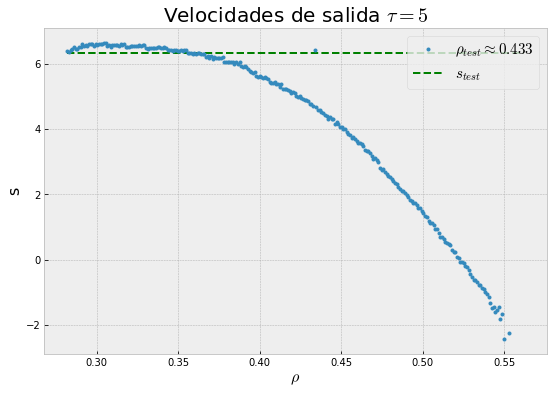

In [89]:
plt.plot(rhos_to_collide/rho_max, vels, ".",label=r"$\rho_{test}\approx 0.433$")
plt.hlines(s_test, rhos_to_collide[0]/rho_max, rhos_to_collide[-1]/rho_max, color="g", ls="--", label=r"$s_{test}$")
plt.title(r"Velocidades de salida $\tau = 5$")
plt.xlabel(r"$\rho$")
plt.ylabel("s")
plt.legend(fontsize=15)
plt.savefig("Charts/Colisiones/Vel_salida_tau_5.png")
plt.show()

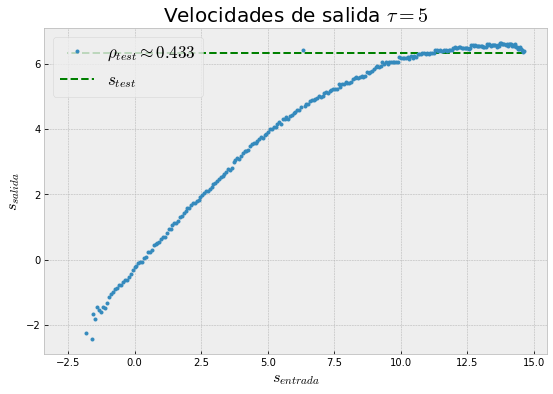

In [90]:
plt.plot(s_collide, vels, ".", label=r"$\rho_{test}\approx 0.433$")
plt.hlines(s_test, s_collide[0], s_collide[-1], color="g", ls="--", label=r"$s_{test}$")
plt.title(r"Velocidades de salida $\tau = 5$")
plt.xlabel(r"$s_{entrada}$")
plt.ylabel(r"$s_{salida}$")
plt.legend(fontsize=17)
plt.savefig("Charts/Colisiones/Vel_salida_s_tau_5.png")
plt.show()

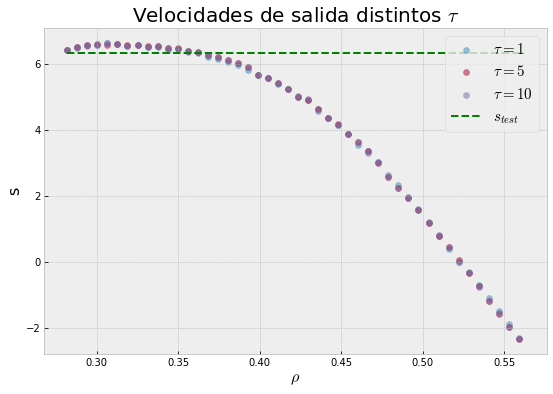

In [34]:
import numpy as np
salto = 6

rhos_to_plot = np.take(rhos_to_collide/rho_max, range(0, 274, salto))
vels_arr = np.array(vels)
vels_2_arr = np.array(vels_2)
vels_3_arr = np.array(vels_3)

vels_to_plot = np.take(vels_arr, range(0, 274, salto))
vels_2_to_plot = np.take(vels_2_arr, range(0, 274, salto))
vels_3_to_plot = np.take(vels_3_arr, range(0, 274, salto))

plt.scatter(rhos_to_plot, vels_3_to_plot, label=r"$\tau=1$", alpha=0.5)
plt.scatter(rhos_to_plot, vels_to_plot, label=r"$\tau=5$", alpha=0.5)
plt.scatter(rhos_to_plot, vels_2_to_plot, label=r"$\tau=10$", alpha=0.5)


plt.hlines(s_test, rhos_to_collide[0]/rho_max, rhos_to_collide[-1]/rho_max, color="g", ls="--", label=r"$s_{test}$")
plt.title(r"Velocidades de salida distintos $\tau$")
plt.xlabel(r"$\rho$")
plt.ylabel("s")

#plt.xlim(rhos_to_collide[0]/rho_max-0.01, 0.45)
#plt.ylim(5, 7)
plt.legend(fontsize=15)
plt.savefig("Charts/Colisiones/Vel_salida_taus.png")
plt.show()

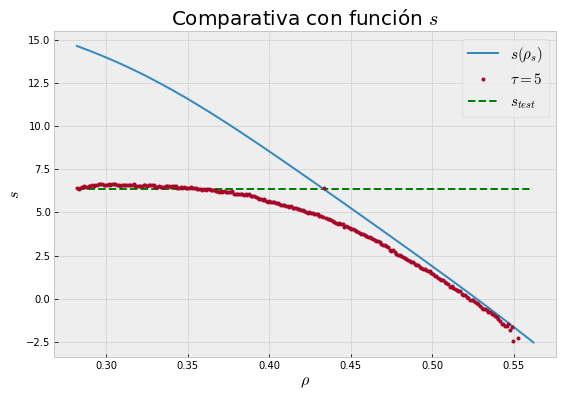

In [91]:

m_to_plot = get_m(1/(rhos_to_collide))
s_to_plot = get_s(m_to_plot, 1/(rhos_to_collide))
plt.plot(rhos_to_collide/rho_max, s_to_plot, label=r"$s(\rho_s)$")

plt.plot(rhos_to_collide/rho_max, vels, ".", label=r"$\tau = 5$")
plt.hlines(s_test, rhos_to_collide[0]/rho_max, rhos_to_collide[-1]/rho_max, color="g", ls="--", label=r"$s_{test}$")
plt.title(r"Comparativa con función $s$")
plt.xlabel(r"$\rho$")
plt.ylabel("$s$")
plt.legend(fontsize=15)
plt.savefig("Charts/Colisiones/comparativa_s.png")
plt.show()

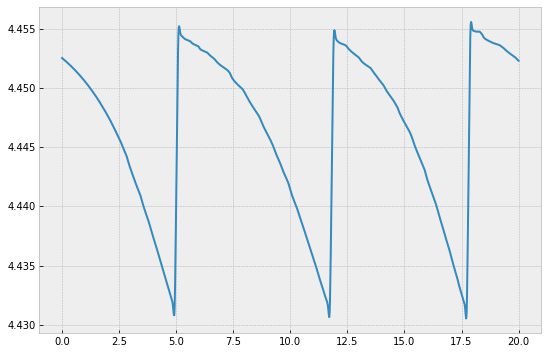

In [166]:
rho_s = rhos_to_collide[147]/rho_max
Q, x = dic_sols[rho_s]

L = x[-1] - x[0]
T = 20
t_to_plot = np.linspace(0, T, len(Q)//2)
dx = L/N

integral = density_integral(x, dx, len(Q)//2, Q)
plt.plot(t_to_plot, integral)
#plt.ylim(2.22, 2.24)
plt.show()

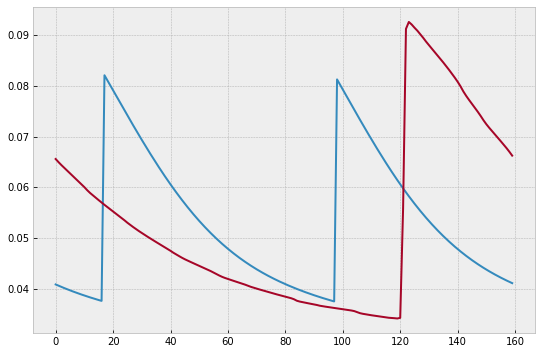

In [163]:
plt.plot(Q[0][0])
plt.plot(Q[-1][0])

In [132]:
np.where(np.isclose(rhos_to_collide, rho_s_test, rtol=1e-2))

(array([144, 145, 146, 147, 148, 149, 150, 151]),)

In [139]:
rhos_to_collide[np.isclose(rhos_to_collide, rho_s_test, rtol=1e-2)]/rho_max

array([0.42970512, 0.4307312 , 0.43175728, 0.43278336, 0.43382996,
       0.43485603, 0.43588211, 0.43690819])

In [141]:
rho_s_test/rho_max

0.43333743795471785

In [149]:
rhos_to_collide[148]/rho_max

0.4338299555247423